# Credit Risk Analysis

# Convert this cell to code if we need to reinstall qiskit_aer
!python -m pip uninstall qiskit_aer --yes
!python -m pip install qiskit_aer
!pip install qiskit-finance

In [1]:
import CRA_util
import CRA_ExperimentOnAE

In [2]:
#basic python libraries for math and visualization
import numpy as np
import matplotlib.pyplot as plt

# Qiskit Finance
from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel 

#Qiskit libraries for our code
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit.library import IntegerComparator
from qiskit.algorithms import EstimationProblem
from qiskit_aer.primitives import Sampler
from qiskit.circuit.library import WeightedAdder
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit.algorithms import  IterativePhaseEstimation

In [3]:
# set parameters for the Gaussian Conditional Independence model
n_z = 2 
z_max = 4 #z sample
z_values = np.linspace(-z_max, z_max, 2**n_z)
p_zeros = [0.15, 0.25]#[0.1, 0.1] #,0.1] # probability of default when z = 0
rhos = [0.1, 0.05]#,0.1] # sensitivity
uncertinitiyModel = GaussianConditionalIndependenceModel(n_z, z_max, p_zeros, rhos)

# Step1 : Create UncertinitiyModel using Gaussian Conditional Indepence Model (normal distrubution)

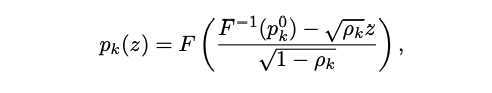

In [4]:
uncertinitiyModel.draw()

┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │  P(X) │
q_2: ┤2      ├
     │       │
q_3: ┤3      ├
     └───────┘

In [5]:
u_measure = uncertinitiyModel.measure_all(inplace=False)

sampler = Sampler()
job = sampler.run(u_measure)
bprobabilities = job.result().quasi_dists[0].binary_probabilities()
print(bprobabilities)
counts = job.result()
print(counts)

{'0011': 0.0009765625, '0101': 0.0771484375, '1010': 0.0751953125, '1000': 0.0009765625, '1110': 0.0048828125, '1001': 0.1279296875, '0110': 0.0302734375, '0001': 0.2392578125, '0000': 0.0009765625, '0010': 0.408203125, '1101': 0.0341796875}
SamplerResult(quasi_dists=[{3: 0.0009765625, 5: 0.0771484375, 10: 0.0751953125, 8: 0.0009765625, 14: 0.0048828125, 9: 0.1279296875, 6: 0.0302734375, 1: 0.2392578125, 0: 0.0009765625, 2: 0.408203125, 13: 0.0341796875}], metadata=[{'shots': 1024, 'simulator_metadata': {'parallel_state_update': 4, 'parallel_shots': 1, 'sample_measure_time': 0.000470851, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'device': 'CPU', 'active_input_qubits': [0, 1, 2, 3], 'measure_sampling': True, 'num_clbits': 4, 'input_qubit_map': [[3, 3], [2, 2], [1, 1], [0, 0]], 'num_qubits': 4, 'method': 'statevector', 'fusion': {'applied': False, 'max_fused_qubits': 5, 'threshold': 14, 'enabled': True}}}])


# Step2: Analyze uncertainty circuit and determine exact solutions

In [6]:

K = len(p_zeros)
lgd = [1, 2]#,1]
alpha = 0.05
p_z = np.zeros(2**n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = uncertinitiyModel.num_qubits
print(num_qubits)
for i, prob in bprobabilities.items():
    # extract value of Z and corresponding probability
    i_normal = int(i[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k
    loss = 0
    for k in range(K):
        if i[K - k - 1] == "1":
            p_default[k] += prob
            loss += lgd[k]

    values += [loss]
    probabilities += [prob]


values = np.array(values)
probabilities = np.array(probabilities)

expected_loss = np.dot(values, probabilities)
losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1 - alpha)
exact_var = losses[i_var]
exact_cvar = np.dot(pdf[(i_var + 1) :], losses[(i_var + 1) :]) / sum(pdf[(i_var + 1) :])

4


In [7]:
print("Expected Loss E[L]:                %.4f" % expected_loss)
print("Value at Risk VaR[L]:              %.4f" % exact_var)
print("P[L <= VaR[L]]:                    %.4f" % cdf[exact_var])
print("Conditional Value at Risk CVaR[L]: %.4f" % exact_cvar)

Expected Loss E[L]:                0.6328
Value at Risk VaR[L]:              2.0000
P[L <= VaR[L]]:                    0.9609
Conditional Value at Risk CVaR[L]: 3.0000


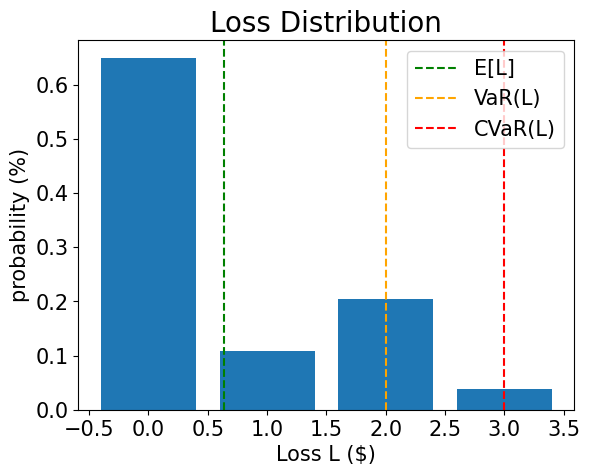

In [8]:
# plot loss PDF, expected loss, var, and cvar
plt.bar(losses, pdf)
plt.axvline(expected_loss, color="green", linestyle="--", label="E[L]")
plt.axvline(exact_var, color="orange", linestyle="--", label="VaR(L)")
plt.axvline(exact_cvar, color="red", linestyle="--", label="CVaR(L)")
plt.legend(fontsize=15)
plt.xlabel("Loss L ($)", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Loss Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

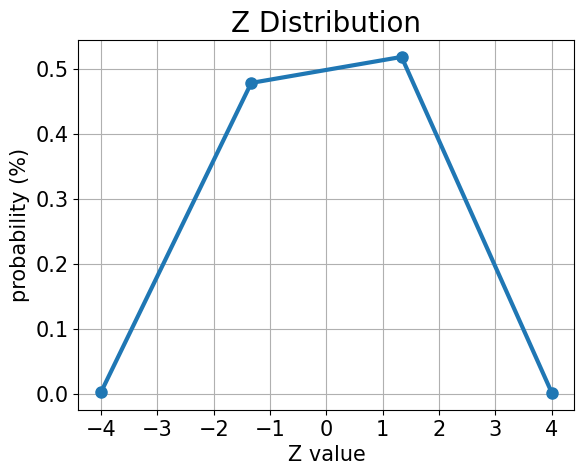

In [9]:
# plot results for Z
plt.plot(z_values, p_z, "o-", linewidth=3, markersize=8)
plt.grid()
plt.xlabel("Z value", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Z Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

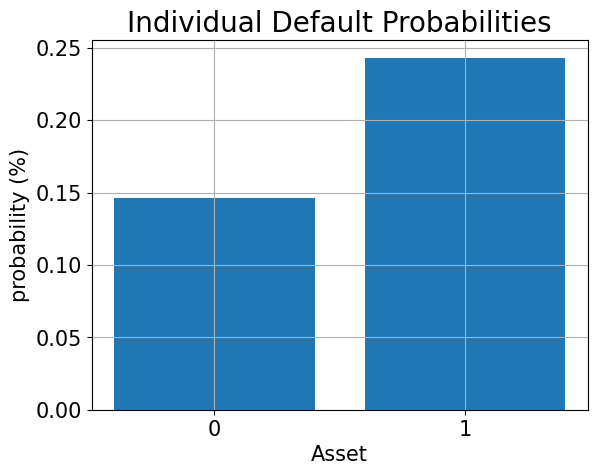

In [10]:
# plot results for default probabilities
plt.bar(range(K), p_default)
plt.xlabel("Asset", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Individual Default Probabilities", size=20)
plt.xticks(range(K), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

In [11]:
# add Z qubits with weight/loss
agg = WeightedAdder(n_z + K, [0] * n_z + lgd)
#agg = VBERippleCarryAdder(n_z + K, [0] * n_z + lgd)

In [12]:
# define linear objective function
breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum(lgd)
c_approx = 0.25

objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slope=slopes,
    offset=offsets,
    # max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2**agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

In [13]:
# define the registers for convenience and readability
qr_state = QuantumRegister(uncertinitiyModel.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
qr_obj = QuantumRegister(1, "objective")
print("Total Qubits used:", uncertinitiyModel.num_qubits + agg.num_sum_qubits+ agg.num_carry_qubits + 1)
# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name="A")

# load the random variable
state_preparation.append(uncertinitiyModel.to_gate(), qr_state)

# aggregate
state_preparation.append(agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])

# linear objective function
state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])

# uncompute aggregation
state_preparation.append(agg.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

# draw the circuit
state_preparation.draw()

Total Qubits used: 8


┌───────┐┌────────┐      ┌───────────┐
  state_0: ┤0      ├┤0       ├──────┤0          ├
           │       ││        │      │           │
  state_1: ┤1      ├┤1       ├──────┤1          ├
           │  P(X) ││        │      │           │
  state_2: ┤2      ├┤2       ├──────┤2          ├
           │       ││        │      │           │
  state_3: ┤3      ├┤3       ├──────┤3          ├
           └───────┘│  adder │┌────┐│  adder_dg │
objective: ─────────┤        ├┤2   ├┤           ├
                    │        ││    ││           │
    sum_0: ─────────┤4       ├┤0 F ├┤4          ├
                    │        ││    ││           │
    sum_1: ─────────┤5       ├┤1   ├┤5          ├
                    │        │└────┘│           │
    carry: ─────────┤6       ├──────┤6          ├
                    └────────┘      └───────────┘

In [14]:
state_preparation.decompose().draw()

┌───────┐┌──────────────┐      ┌─────────────────┐
  state_0: ┤0      ├┤0             ├──────┤0                ├
           │       ││              │      │                 │
  state_1: ┤1      ├┤1             ├──────┤1                ├
           │  P(X) ││              │      │                 │
  state_2: ┤2      ├┤2             ├──────┤2                ├
           │       ││              │      │                 │
  state_3: ┤3      ├┤3             ├──────┤3                ├
           └───────┘│  circuit-168 │┌────┐│  circuit-168_dg │
objective: ─────────┤              ├┤2   ├┤                 ├
                    │              ││    ││                 │
    sum_0: ─────────┤4             ├┤0 F ├┤4                ├
                    │              ││    ││                 │
    sum_1: ─────────┤5             ├┤1   ├┤5                ├
                    │              │└────┘│                 │
    carry: ─────────┤6             ├──────┤6                ├
                    └──────────────┘      └─────────────────┘

In [15]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [16]:
# evaluate the result
value = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1) :][0] == "1":
        value += prob

print("Exact Expected Loss:   %.4f" % expected_loss)
print("Exact Operator Value:  %.4f" % value)
print("Mapped Operator value: %.4f" % objective.post_processing(value))

Exact Expected Loss:   0.6328
Exact Operator Value:  0.3770
Mapped Operator value: 0.5600


In [17]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=state_preparation,
    #num_qubits = state_preparation.num_qubits,
    objective_qubits=[len(qr_state)],
    post_processing=objective.post_processing,
)
# construct amplitude estimation
fae = CRA_ExperimentOnAE.FasterAE()
#IterativePhaseEstimation(num_iterations =2,
                              #quantum_instance= ,
#                              sampler= Sampler(run_options={"shots": 100}))
#CRA_ExperimentOnAE.FasterAE()
result = fae.estimate(problem)

# print results
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:    \t%.4f" % expected_loss)
print("Estimated value:\t%.4f" % result.estimation_processed)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact value:    	0.6328
Estimated value:	0.7053
Confidence interval: 	[-1.1065, 3.3026]


In [18]:
# set x value to estimate the CDF
x_eval = 2

comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
comparator.draw()

┌──────┐
state_0: ┤0     ├
         │      │
state_1: ┤1     ├
         │  cmp │
compare: ┤2     ├
         │      │
    a24: ┤3     ├
         └──────┘

In [19]:
state_preparation.draw()

┌───────┐┌────────┐      ┌───────────┐
  state_0: ┤0      ├┤0       ├──────┤0          ├
           │       ││        │      │           │
  state_1: ┤1      ├┤1       ├──────┤1          ├
           │  P(X) ││        │      │           │
  state_2: ┤2      ├┤2       ├──────┤2          ├
           │       ││        │      │           │
  state_3: ┤3      ├┤3       ├──────┤3          ├
           └───────┘│  adder │┌────┐│  adder_dg │
objective: ─────────┤        ├┤2   ├┤           ├
                    │        ││    ││           │
    sum_0: ─────────┤4       ├┤0 F ├┤4          ├
                    │        ││    ││           │
    sum_1: ─────────┤5       ├┤1   ├┤5          ├
                    │        │└────┘│           │
    carry: ─────────┤6       ├──────┤6          ├
                    └────────┘      └───────────┘

In [20]:
state_preparation = CRA_util.get_cdf_circuit(x_eval,uncertinitiyModel,agg)

Total Qubits used: 9


In [21]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [22]:
# evaluate the result
var_prob = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1) :][0] == "1":
        var_prob += prob

print("Operator CDF(%s)" % x_eval + " = %.4f" % var_prob)
print("Exact    CDF(%s)" % x_eval + " = %.4f" % cdf[x_eval])

Operator CDF(2) = 0.9541
Exact    CDF(2) = 0.9609


In [23]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(state_preparation=state_preparation, objective_qubits=[len(qr_state)])
# construct amplitude estimation
fae_cdf = CRA_ExperimentOnAE.FasterAE()
result_cdf = fae_cdf.estimate(problem)

# print results
conf_int = np.array(result_cdf.confidence_interval)
print("Exact value:    \t%.4f" % cdf[x_eval])
print("Estimated value:\t%.4f" % result_cdf.estimation)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact value:    	0.9609
Estimated value:	0.9577
Confidence interval: 	[0.5647, 1.4460]


In [24]:
# run bisection search to determine VaR
objective = lambda x: CRA_util.run_ae_for_cdf(x,uncertinitiyModel,agg,qr_state)
bisection_result = CRA_util.bisection_search(
    objective, 1 - alpha, min(losses) - 1, max(losses), low_value=0, high_value=1
)
var = bisection_result["level"]

--------------------------------------------------------------------
start bisection search for target value 0.950
--------------------------------------------------------------------
low_level    low_value    level    value    high_level    high_value
--------------------------------------------------------------------
Total Qubits used: 9
-1           0.000         1       0.749     3            1.000
Total Qubits used: 9
 1           0.749         2       0.955     3            1.000
--------------------------------------------------------------------
finished bisection search
--------------------------------------------------------------------


In [25]:
print("Estimated Value at Risk: %2d" % var)
print("Exact Value at Risk:     %2d" % exact_var)
print("Estimated Probability:    %.3f" % bisection_result["value"])
print("Exact Probability:        %.3f" % cdf[exact_var])

Estimated Value at Risk:  2
Exact Value at Risk:      2
Estimated Probability:    0.955
Exact Probability:        0.961


In [26]:
# define linear objective
breakpoints = [0, var]
slopes = [0, 1]
offsets = [0, 0]  # subtract VaR and add it later to the estimate
f_min = 0
f_max = 3 - var
c_approx = 0.25

cvar_objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slopes,
    offsets,
    domain=(0, 2**agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

cvar_objective.draw()

┌────┐
q170_0: ┤0   ├
        │    │
q170_1: ┤1   ├
        │    │
  q171: ┤2 F ├
        │    │
a101_0: ┤3   ├
        │    │
a101_1: ┤4   ├
        └────┘

In [27]:
# define the registers for convenience and readability
qr_state = QuantumRegister(uncertinitiyModel.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
qr_obj = QuantumRegister(1, "objective")
qr_work = QuantumRegister(cvar_objective.num_ancillas - len(qr_carry), "work")

print("Total Qubits used:",uncertinitiyModel.num_qubits+agg.num_sum_qubits+
          agg.num_carry_qubits+1+ cvar_objective.num_ancillas - len(qr_carry))
# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, qr_work, name="A")

# load the random variable
state_preparation.append(uncertinitiyModel, qr_state)

# aggregate
state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:])

# linear objective function
state_preparation.append(cvar_objective, qr_sum[:] + qr_obj[:] + qr_carry[:] + qr_work[:])

# uncompute aggregation
state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

Total Qubits used: 9


In [28]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [29]:
# evaluate the result
value = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1)] == "1":
        value += prob

# normalize and add VaR to estimate
value = cvar_objective.post_processing(value)
d = 1.0 - bisection_result["value"]
v = value / d if d != 0 else 0
normalized_value = v + var
print("Estimated CVaR: %.4f" % normalized_value)
print("Exact CVaR:     %.4f" % exact_cvar)

Estimated CVaR: 1.8931
Exact CVaR:     3.0000


In [30]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=cvar_objective.post_processing,
)
# construct amplitude estimation
fae_cvar = CRA_ExperimentOnAE.FasterAE()
result_cvar = fae_cvar.estimate(problem)

In [31]:
# print results
d = 1.0 - bisection_result["value"]
v = result_cvar.estimation_processed / d if d != 0 else 0
print("Exact CVaR:    \t%.4f" % exact_cvar)
print("Estimated CVaR:\t%.4f" % (v + var))

Exact CVaR:    	3.0000
Estimated CVaR:	3.1178


#References
1. https://qiskit.org/documentation/stubs/qiskit.algorithms.IterativeAmplitudeEstimation.html
2. https://github.com/qiskit-community/qiskit-finance/blob/stable/0.3/docs/tutorials/00_amplitude_estimation.ipynb
3. https://qiskit.org/documentation/tutorials/circuits_advanced/01_advanced_circuits.html
4. https://qiskit.org/documentation/_modules/qiskit/circuit/library/arithmetic/linear_amplitude_function.html
5. 


Papers refered:
https://arxiv.org/pdf/1907.03044.pdf
https://arxiv.org/pdf/1412.1183.pdf
file:///Users/neha/Downloads/s41534-019-0130-6%20(1).pdf
